In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import time

from IPython.display import clear_output
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils import shuffle
from skimage.feature import graycomatrix
from keras.models import Model

In [2]:
# DATA PRE-PROCESSING FUNCTIONS

# min-max normalization
def normalize(array):
    max = np.amax(array)
    min = np.amin(array)

    return (array-min) / (max-min)

# log transform and median filtering
def process_bframe(file):
    B_frame = pd.read_csv(file, header=None).to_numpy() + 1
    B_frame = np.log(B_frame) # all values > 0
    B_frame = cv2.medianBlur(B_frame.astype("float32"), 3)

    return B_frame

# returns list of B-frame slices evenly sampled from left to right
def slice_bframe(B_frame, slice_width, step):
    slice_list = []
    num_possible_slices = B_frame.shape[1] // slice_width

    for i in range(0, num_possible_slices, step):
        slice = B_frame[:, i*slice_width:(i+1)*slice_width]
        slice_list.append(slice)

    return slice_list

# returns surface depth in given B-frame slice
def extract_edge(slice):
    profile = np.sum(slice[100:2000, :], axis=1)
    avg_profile = np.mean(np.reshape(profile, (95, 20)), axis=1)
    frac_max = 0.95 * np.amax(avg_profile)

    # plt.plot(profile)
    # plt.show()
    # plt.plot(avg_profile)
    # plt.show()

    for i in range(len(avg_profile)-1):
        prior = avg_profile[i]
        next = avg_profile[i+1]
        
        if((prior<frac_max) and (next>frac_max)):
            return i*20 + 100

def convert_to_texture(trunc_slice, min_val, max_val): 
    rescale = np.interp(trunc_slice, (min_val, max_val), (0, 99)).astype(int)
    # texture = graycomatrix(rescale, [14, 15, 16], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=100)
    texture = graycomatrix(rescale, [15], [0], levels=100)
    texture = np.reshape(texture, (100, 100, 1))
    texture = np.average(texture, axis=2)

    return texture.astype("float32")

Total B-frames: 91
ExVivo_S4_P2_T2_2017-08-24_0181.oct.csv


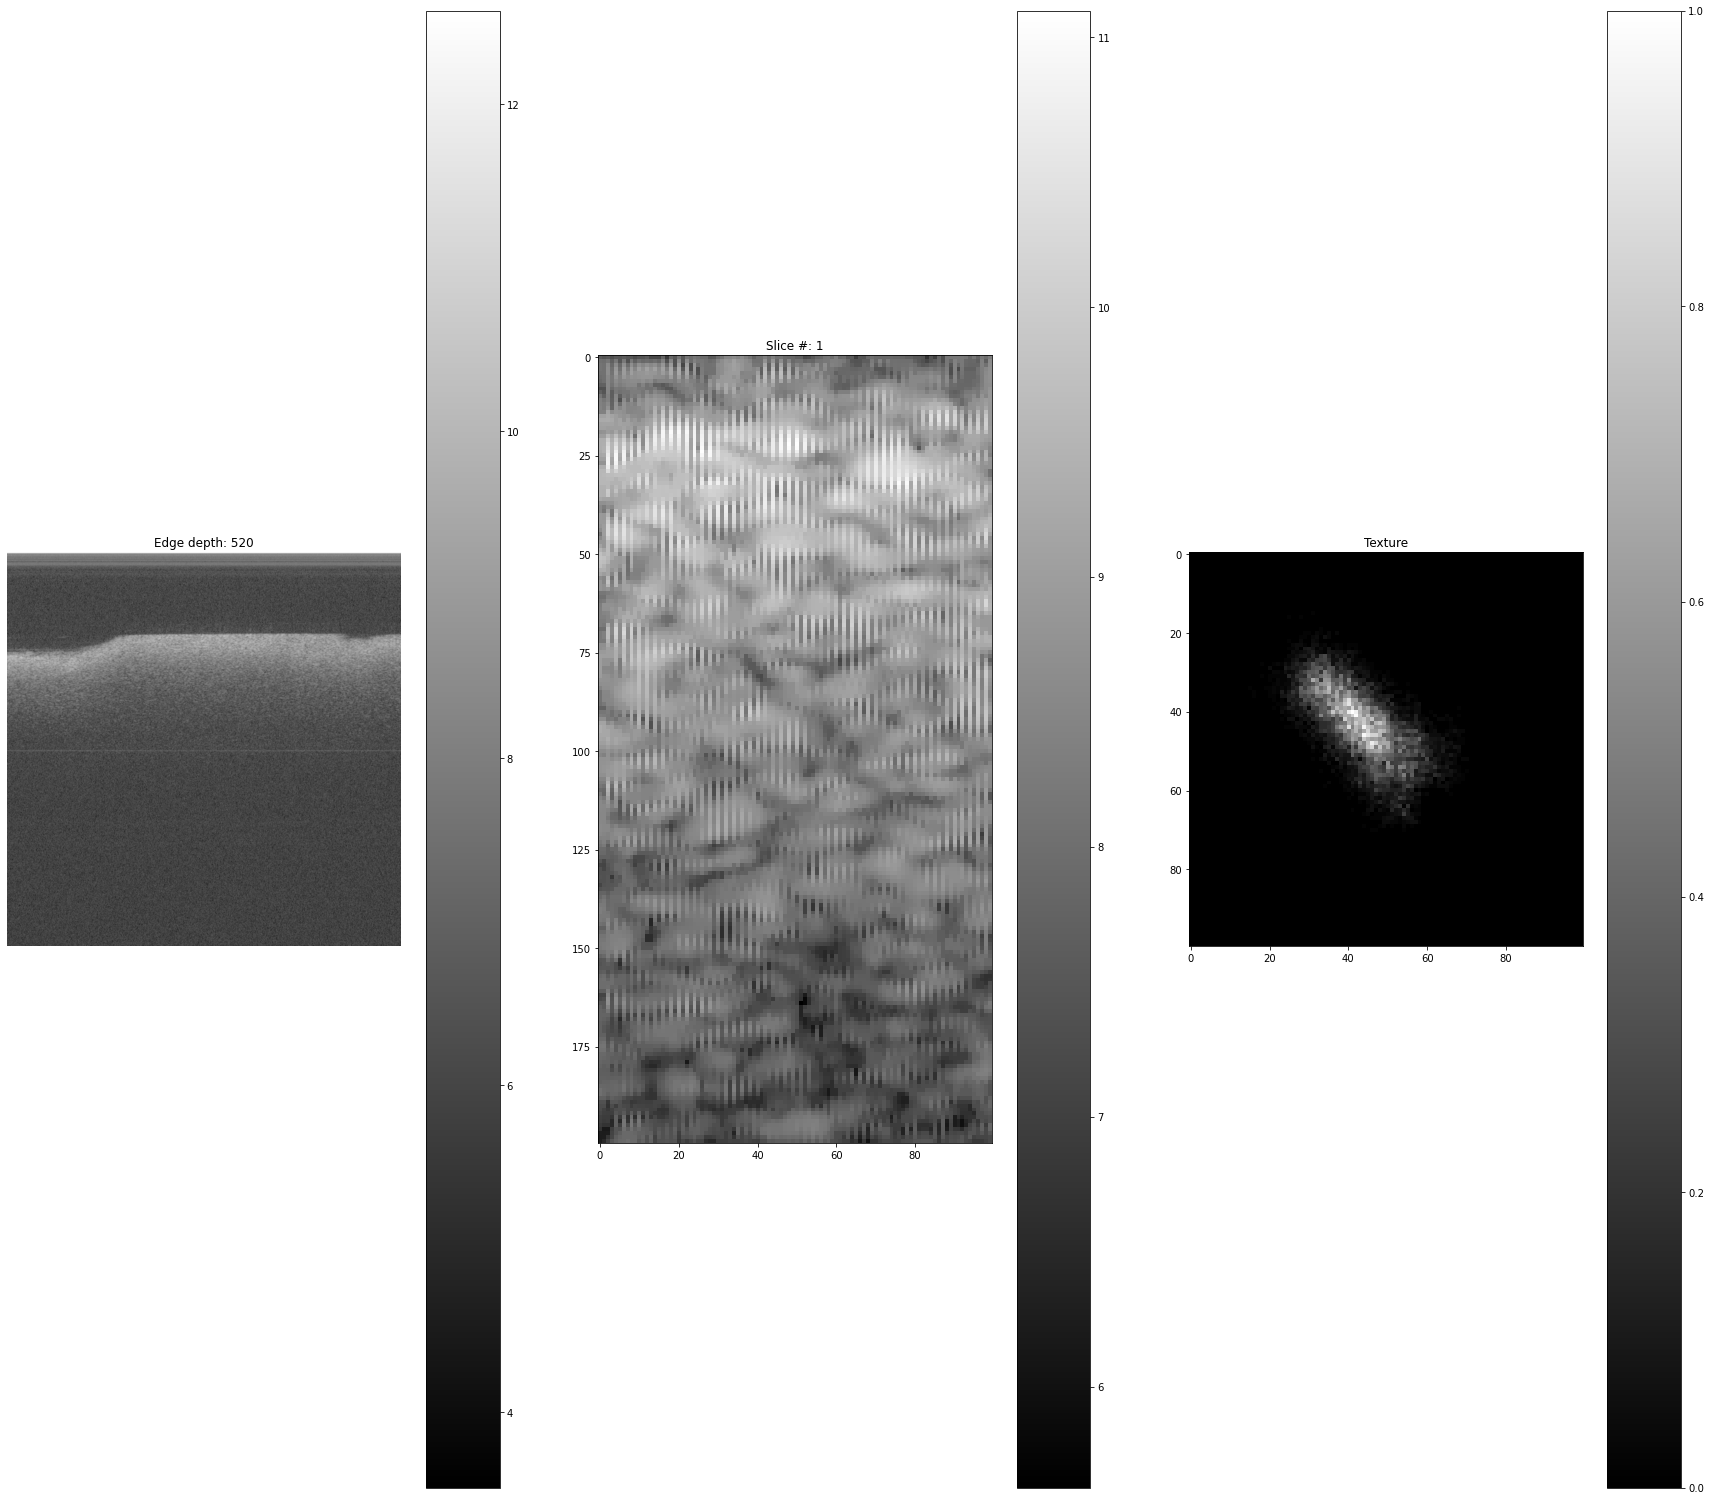

In [4]:
# VISUALIZE EFFECTS OF PRE-PROCESSING ON TRAINING SAMPLES
# DELETE IMPROPER B-FRAMES IF NECESSARY

dir = r"D:\testing_data\non_cancer\8-24-2017-C1-s4\\"
data = os.listdir(dir)
print("Total B-frames: " + str(len(data)))
data = [data[90]]

for file in data: 
    B_frame = process_bframe(dir + file)
    slices = slice_bframe(B_frame, slice_width=100, step=3)

    for i in range(1):
        print(file)
        B_frame_slice = slices[i]
        edge_depth = extract_edge(B_frame_slice)
        B_frame_slice = B_frame_slice[edge_depth:edge_depth+200]
        slice_texture = normalize(convert_to_texture(B_frame_slice, 4.11, 13.92))

        # original B-frame
        plt.subplots(1,3, figsize=(30,30))
        plt.subplot(1,3,1)
        plt.title("Edge depth: " + str(edge_depth))
        plt.imshow(B_frame, cmap="gray")
        plt.colorbar()
        plt.axis("off")
        # plt.axhline(y=edge_depth, color='r', linestyle='-', linewidth=0.5)

        # B-frame slice
        plt.subplot(1,3,2)
        plt.title("Slice #: " + str(i+1))
        plt.imshow(B_frame_slice, cmap="gray")
        plt.colorbar()

        plt.subplot(1,3,3)
        plt.title("Texture")
        plt.imshow(slice_texture, cmap="gray")
        plt.colorbar()
        plt.show()
        
        # action = input("Delete file? (y/n)")

        # if(action == "y"):
        #     os.remove(dir+file)
        
        time.sleep(1)
        clear_output(wait=True)

In [4]:
# LOAD FILE PATHS AND LABELS INTO NP ARRAYS

train_data_dir = r"D:\brain_cancer_oct\\training_data"
test_data_dir = r"D:\brain_cancer_oct\\testing_data"

# "D:/training_data"
# -- cancer
# ---- _.oct.csv
# -- non_cancer
# ---- _.oct.csv

# iter_0
# subdir = "D:/training_Data"
# dirs = [cancer, non_cancer]
# files = []

# iter_1
# subdir = "D:/training_Data/cancer"
# dirs = []
# files [_0000.oct.csv, _0001.oct.csv, etc.]

def load_files(data_dir):
    label = "None"
    X_fnames = []
    Y_labels = []

    for subdir, dirs, files in os.walk(data_dir):
        if(subdir == data_dir + "\cancer"):
            label = 0
        elif(subdir == data_dir + "\\non_cancer"):
            label = 1
        
        print("%s: %s" %(subdir, label))

        for file in files:
            full_path = os.path.join(subdir, file)
            X_fnames.append(full_path)
            Y_labels.append(label)

    Y_labels = tf.keras.utils.to_categorical(Y_labels) # 0/cancerous -> [1 0], 1/non-cancerous -> [0 1]
    return shuffle(X_fnames, Y_labels)

X_train_fnames, Y_train_labels = load_files(train_data_dir)
print("Total training B-frames: " + str(len(X_train_fnames)))
print("")

X_test_fnames, Y_test_labels = load_files(test_data_dir)
print("Total testing B-frames: " + str(len(X_test_fnames)))

D:\brain_cancer_oct\\training_data: None
D:\brain_cancer_oct\\training_data\cancer: 0
D:\brain_cancer_oct\\training_data\cancer\3-21-2017-s1: 0
D:\brain_cancer_oct\\training_data\cancer\3-21-2017-s2: 0
D:\brain_cancer_oct\\training_data\cancer\6-24-2019-s3: 0
D:\brain_cancer_oct\\training_data\cancer\9-11-2018-s2: 0
D:\brain_cancer_oct\\training_data\cancer\9-28-2020-Tumor: 0
D:\brain_cancer_oct\\training_data\non_cancer: 1
D:\brain_cancer_oct\\training_data\non_cancer\10-5-2020-C1-NormalWhiteMatter: 1
D:\brain_cancer_oct\\training_data\non_cancer\4-24-2018-s2: 1
D:\brain_cancer_oct\\training_data\non_cancer\8-24-2017-C2-s1: 1
Total training B-frames: 833

D:\brain_cancer_oct\\testing_data: None
D:\brain_cancer_oct\\testing_data\cancer: 0
D:\brain_cancer_oct\\testing_data\cancer\6-08-2017-s2: 0
D:\brain_cancer_oct\\testing_data\cancer\6-24-2019-s2: 0
D:\brain_cancer_oct\\testing_data\non_cancer: 1
D:\brain_cancer_oct\\testing_data\non_cancer\8-24-2017-C1-s4: 1
D:\brain_cancer_oct\\test

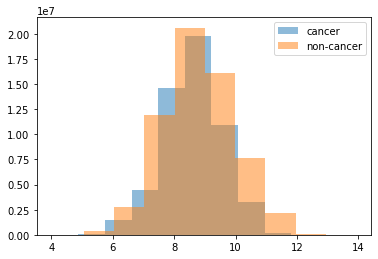

4.014147
13.925418


In [60]:
# CALCULATE DATASET STATISTICS

cancer_slice = []
non_cancer_slice = []

for i in range(833):
    file = X_train_fnames[i]
    label = Y_train_labels[i]
    B_frame = process_bframe(file)
    slices = slice_bframe(B_frame, slice_width=100, step=3)

    for k in range(7):
        B_frame_slice = slices[k]
        edge_depth = extract_edge(B_frame_slice)
        B_frame_slice = B_frame_slice[edge_depth:edge_depth+200]

        if(label[0] == 1):
            cancer_slice.append(B_frame_slice)
        else: 
            non_cancer_slice.append(B_frame_slice)

cancer_slice, non_cancer_slice = np.stack(cancer_slice, axis=0), np.stack(non_cancer_slice, axis=0)

plt.hist(cancer_slice.flatten(), alpha=0.5, label="cancer")
plt.hist(non_cancer_slice.flatten(), alpha=0.5, label="non-cancer")
plt.legend()
plt.show()

# used for global min-max norm
min_val = np.amin(cancer_slice.flatten())
max_val = np.amax(non_cancer_slice.flatten())
print(min_val)
print(max_val)

In [6]:
# LOAD DATA INTO RAM

min_val = 4.014147
max_val = 13.925418

def load_data(fnames, labels, COM=False): 
    X_train = []
    Y_train = []
    file_num = 0

    for file in fnames: 
        B_frame = process_bframe(file)
        slices = slice_bframe(B_frame, slice_width=100, step=3)
        num_slices = len(slices)

        for i in range(num_slices):
            B_frame_slice = slices[i]
            edge_depth = extract_edge(B_frame_slice)
            B_frame_slice = B_frame_slice[edge_depth:edge_depth+200]

            if(COM):
                slice_texture = normalize(convert_to_texture(B_frame_slice, min_val, max_val))
                X_train.append(slice_texture)
            else: 
                # B_frame_slice = 1 - ((B_frame_slice-min_val)/(max_val-min_val))
                X_train.append(B_frame_slice)

        frame_label = labels[file_num]
        Y_train += [frame_label] * num_slices
        file_num += 1

    X_train, Y_train = np.expand_dims(np.stack(X_train, axis=0), axis=3), np.stack(Y_train, axis=0)
    return shuffle(X_train, Y_train)

In [11]:
try: 
    del cancer_slice
    del non_cancer_slice
except:
    print("Already deleted")

X_train, Y_train = load_data(X_train_fnames[0:100], Y_train_labels[0:100], True)
print("(#_examples, img_height, img_width, img_channels): " + str(X_train.shape))
print("(#_examples, #_classes): " + str(Y_train.shape))

Already deleted
(#_examples, img_height, img_width, img_channels): (700, 100, 100, 1)
(#_examples, #_classes): (700, 2)


<Figure size 432x288 with 0 Axes>

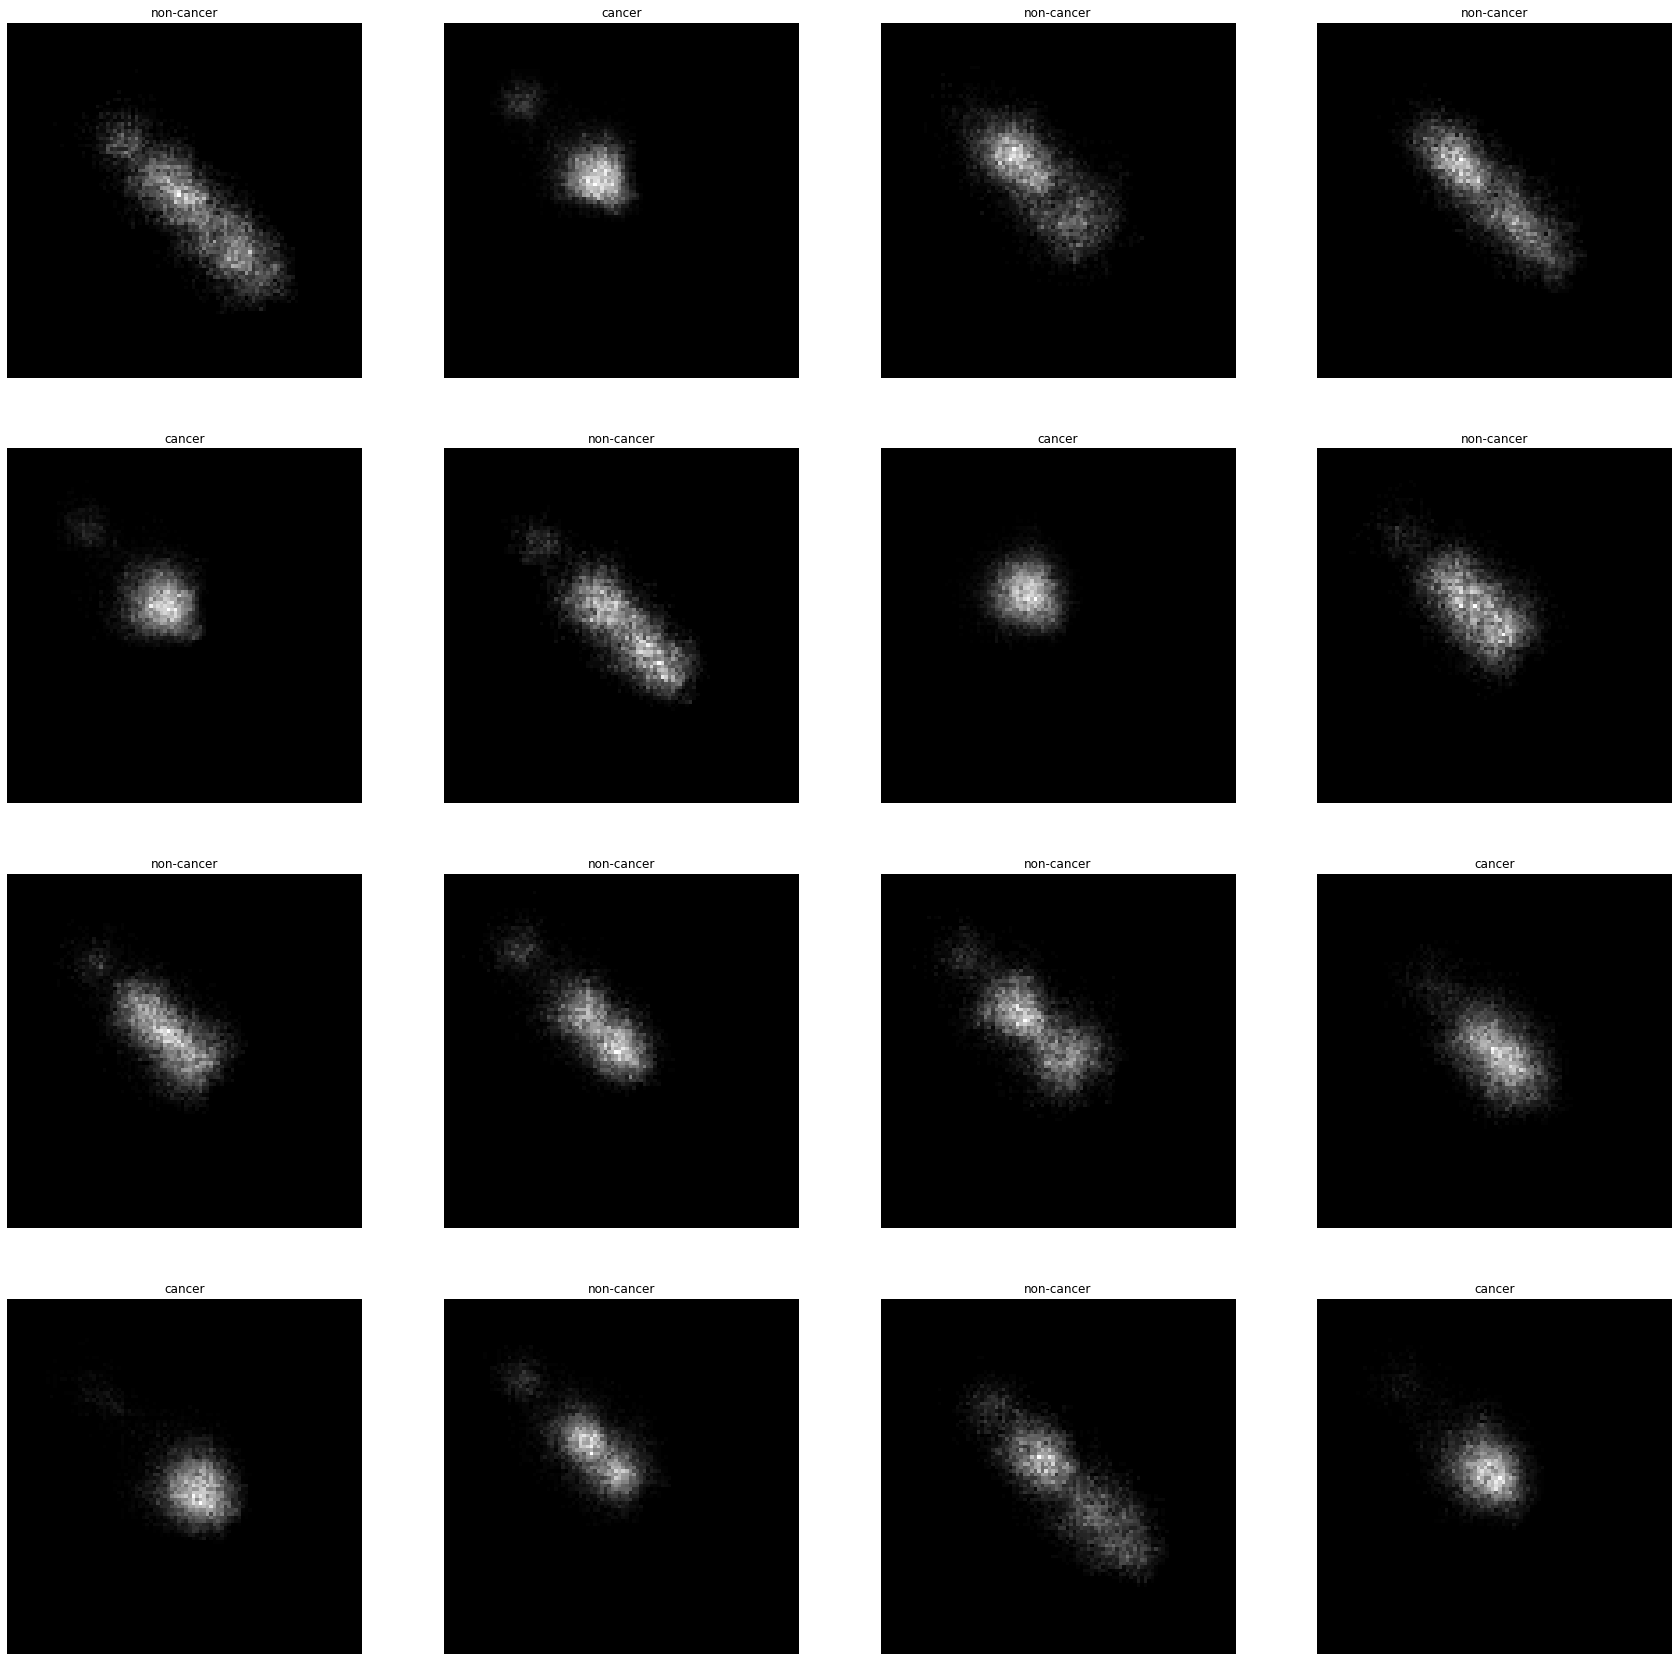

In [12]:
plt.tight_layout()
plt.subplots(4,4, figsize=(30,30))

n = 0
convert = False

for i in range(16):
  plt.subplot(4,4,i+1)
  input = X_train[i+16*n, :, :]
  label = Y_train[i+16*n]

  if(label[0]==1):
    plt.title("cancer")
  else:
    plt.title("non-cancer")

  plt.axis("off")
  if(convert):
    slice_texture = normalize(convert_to_texture(np.squeeze(input, axis=2), min_val, max_val))
    plt.imshow(slice_texture, cmap="gray")
  else: 
    plt.imshow(input, cmap="gray")
  #plt.colorbar()
plt.show()

In [8]:
# CNN CLASSIFICATION MODELS

class texture_CNN(tf.keras.Model):
    def __init__(self, filter_size, activation, padding):
        super().__init__()
        # convolutional layers
        self.c1 = tf.keras.layers.Conv2D(32, filter_size, strides=2, activation=activation, padding=padding)
        self.p1 = tf.keras.layers.MaxPooling2D(filter_size, strides=2)
        self.c2 = tf.keras.layers.Conv2D(32, filter_size, strides=2, activation=activation, padding=padding, name="gradmaps")
        self.p2 = tf.keras.layers.MaxPooling2D(filter_size, strides=2)
        self.c3 = tf.keras.layers.Conv2D(32, filter_size, strides=2, activation=activation, padding=padding)
        self.c4 = tf.keras.layers.Conv2D(16, filter_size, strides=2, activation=None, padding=padding)

        # dense layers
        self.f1 = tf.keras.layers.Flatten(name="embedding")
        self.dropout1 = tf.keras.layers.Dropout(0.5)
        self.d1 = tf.keras.layers.Dense(2, activation='softmax')
        self.full_model = None

    def call(self, inputs):
        x = self.c1(inputs)
        x = self.p1(x)
        x = self.c2(x)
        x = self.p2(x)
        x = self.c3(x)
        x = self.c4(x)
        
        x = self.f1(x)
        x = self.dropout1(x, training=True)
        return self.d1(x)
        
    def model(self):
        inputs = tf.keras.Input(shape=(100,100,1))
        self.full_model = tf.keras.Model(inputs=[inputs], outputs=self.call(inputs))
        return self.full_model

    def get_embedding(self):
        intermediate = tf.keras.models.Model(inputs=self.model().input, outputs=self.full_model.get_layer("embedding").output)
        return intermediate

    def get_gradcam(self): 
        intermediate2 = tf.keras.models.Model(inputs=self.model().input, outputs=[self.full_model.get_layer("gradmaps").output, self.full_model.output])
        return intermediate2

# ----------------------------------------------------------------------------------------------

class B_frame_CNN(tf.keras.Model):
    def __init__(self, filter_size, activation, padding):
        super().__init__()
        self.c1 = tf.keras.layers.Conv2D(32, filter_size, strides=(2,1), activation=activation, padding=padding)
        self.c2 = tf.keras.layers.Conv2D(64, filter_size, strides=2, activation=activation, padding=padding)
        self.p1 = tf.keras.layers.MaxPooling2D(filter_size, strides=2)
        self.c3 = tf.keras.layers.Conv2D(128, filter_size, strides=2, activation=activation, padding=padding, name="gradmaps")
        self.p2 = tf.keras.layers.MaxPooling2D(filter_size, strides=2)
        self.c4 = tf.keras.layers.Conv2D(256, filter_size, strides=2, activation=activation, padding=padding)
        self.c5 = tf.keras.layers.Conv2D(256, filter_size, strides=2, activation=activation, padding=padding)

        self.f1 = tf.keras.layers.Flatten()
        self.dropout1 = tf.keras.layers.Dropout(0.5)
        self.d1 = tf.keras.layers.Dense(64, activation=None, name="embedding")
        self.dropout2 = tf.keras.layers.Dropout(0.5)
        self.d2 = tf.keras.layers.Dense(2, activation='softmax')
        self.full_model = None

    def call(self, inputs):
        x = self.c1(inputs)
        x = self.c2(x)
        x = self.p1(x)
        x = self.c3(x)
        x = self.p2(x)
        x = self.c4(x)
        x = self.c5(x)
        
        x = self.f1(x)
        x = self.dropout1(x, training=True)
        x = self.d1(x)
        x = self.dropout2(x, training=True)
        return self.d2(x)
        
    def model(self):
        inputs = tf.keras.Input(shape=(200,100,1))
        self.full_model = tf.keras.Model(inputs=[inputs], outputs=self.call(inputs))
        return self.full_model

    def get_embedding(self):
        intermediate = tf.keras.models.Model(inputs=self.model().input, outputs=self.full_model.get_layer("embedding").output)
        return intermediate

    def get_gradcam(self): 
        intermediate2 = tf.keras.models.Model(inputs=self.model().input, outputs=[self.full_model.get_layer("gradmaps").output, self.full_model.output])
        return intermediate2

# ----------------------------------------------------------------------------------------------

my_bframe_CNN = B_frame_CNN(3, 'relu', 'same')
my_bframe_CNN.model().summary()
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)
opt = tf.keras.optimizers.SGD(learning_rate=0.001)
my_bframe_CNN.compile(
    optimizer=opt, 
    loss=loss, 
    metrics=["accuracy"])

my_texture_CNN = texture_CNN(3, 'relu', 'same')
my_texture_CNN.model().summary()
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
my_texture_CNN.compile(
    optimizer=opt, 
    loss=loss, 
    metrics=["accuracy"])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 100, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
gradmaps (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 256)         295168

Epoch 1/50
583/583 [==============================] - 3s 3ms/step - loss: 0.6789 - accuracy: 0.6407 - val_loss: 0.6490 - val_accuracy: 0.7044

Epoch 00001: val_accuracy improved from -inf to 0.70437, saving model to D:\saved_models\CNN-01-0.70.tf
INFO:tensorflow:Assets written to: D:\saved_models\CNN-01-0.70.tf\assets
Epoch 2/50
583/583 [==============================] - 2s 3ms/step - loss: 0.5329 - accuracy: 0.8553 - val_loss: 0.3200 - val_accuracy: 0.9572

Epoch 00002: val_accuracy improved from 0.70437 to 0.95716, saving model to D:\saved_models\CNN-02-0.96.tf
INFO:tensorflow:Assets written to: D:\saved_models\CNN-02-0.96.tf\assets
Epoch 3/50
583/583 [==============================] - 2s 3ms/step - loss: 0.2952 - accuracy: 0.9575 - val_loss: 0.2791 - val_accuracy: 0.9632

Epoch 00003: val_accuracy improved from 0.95716 to 0.96315, saving model to D:\saved_models\CNN-03-0.96.tf
INFO:tensorflow:Assets written to: D:\saved_models\CNN-03-0.96.tf\assets
Epoch 4/50
583/583 [==============

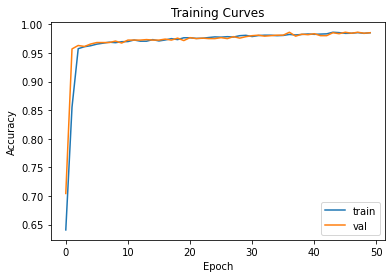

In [50]:
# TRAIN CNN MODEL

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = r"D:\saved_models\\CNN-{epoch:02d}-{val_accuracy:.2f}.tf",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    mode = "max"
)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=15, verbose=1) # stops training after "patience" epochs with no increase in val_accuracy
log_csv = tf.keras.callbacks.CSVLogger("my_logs.csv", separator=",", append=False) # save data for training curves

y_integers = np.argmax(Y_train, axis=1)
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_integers),
                                        y = y_integers                                                  
                                    )
d_class_weights = dict(enumerate(class_weights)) # reduces bias towards majority class

history = my_texture_CNN.fit(
    X_train, 
    Y_train, 
    batch_size = 8,
    shuffle = True,
    epochs = 50, 
    validation_split = 0.2,
    class_weight=d_class_weights, 
    callbacks = [early_stop, log_csv, checkpoint]
)

# if using generators, model.fit would be used like:
# history = brain_CNN_rect.fit(
#     x = batch_generator, 
#     validation_data = val_batch_generator, 
#     epochs = 50, 
#     class_weight=d_class_weights, 
#     callbacks = [checkpoint_callback],
#     max_queue_size = 1,
#     workers = 8
# )

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [7]:
# EVALUATE MODEL ON TESTING SET
X_test, Y_test = load_data(X_test_fnames, Y_test_labels)
X_test_texture, Y_test_texture = load_data(X_test_fnames, Y_test_labels, True)
print("B-frames: (#_examples, img_height, img_width, img_channels): " + str(X_test.shape))
print("Textures: (#_examples, img_height, img_width, img_channels): " + str(X_test_texture.shape))
print("(#_examples, #_classes): " + str(Y_test.shape))

B-frames: (#_examples, img_height, img_width, img_channels): (1610, 200, 100, 1)
Textures: (#_examples, img_height, img_width, img_channels): (1610, 100, 100, 1)
(#_examples, #_classes): (1610, 2)


In [113]:
uncertainty = []

loaded_model = tf.keras.models.load_model("D:\\brain_cancer_oct\saved_models\CNN_texture_suboptimal")

for i in range(20):
    metrics = loaded_model.evaluate(X_test_texture, Y_test_texture, batch_size=1)
    uncertainty.append(metrics[1])

uncertainty = np.asarray(uncertainty)
print("average accuracy: " + str(np.mean(uncertainty)))
print("std of accuracy: " + str(np.std(uncertainty)))

confusion_labels = Y_test_texture[:,0]
confusion_pred = loaded_model.predict(X_test_texture)
confusion_pred = confusion_pred[:,0] > 0.5
confusion_mtx = tf.math.confusion_matrix(confusion_labels, confusion_pred, num_classes=2)
print(confusion_mtx) # can calculate sensitivity and specificity from confusion matrix

1610/1610 [==============================] - 2s 1ms/step - loss: 0.4430 - accuracy: 0.8820
average accuracy: 0.8832298189401626
std of accuracy: 0.0029066727764594192
tf.Tensor(
[[857 144]
 [ 41 568]], shape=(2, 2), dtype=int32)


In [17]:
# CONCATENATE EMBEDDINGS

model1 = B_frame_CNN(3, 'relu', 'same')
model1.load_weights("D:\\brain_cancer_oct\saved_models\CNN_bframe").expect_partial()
model2 = texture_CNN(3, 'relu', 'same')
model2.load_weights("D:\\brain_cancer_oct\saved_models\CNN_texture").expect_partial()
bframe_embedding_CNN = model1.get_embedding()
texture_embedding_CNN = model2.get_embedding()

dir = r"D:\training_data\cancer\3-21-2017-s1\\"
data = os.listdir(dir)
print("Total B-frames: " + str(len(data)))

B_frame = process_bframe(dir + data[40])
B_frame_slice = slice_bframe(B_frame, slice_width=100, step=3)[0]
edge_depth = extract_edge(B_frame_slice)
B_frame_slice = B_frame_slice[edge_depth:edge_depth+200]

def concatenate_embeddings(slice):
    slice_texture = normalize(convert_to_texture(slice, min_val, max_val))
    bframe_embedding = bframe_embedding_CNN.__call__(np.reshape(slice, (1, 200, 100, 1)))
    texture_embedding = texture_embedding_CNN.__call__(np.reshape(slice_texture, (1, 100, 100, 1)))

    return np.concatenate((bframe_embedding, texture_embedding), axis=1)

# X_set can be generated from load_data with COM=False
def load_embedding_data(X_set):
    ensemble_train = []
    num_examples = X_set.shape[0]

    for i in range(num_examples):
        B_frame_slice = np.squeeze(X_set[i,:,:])
        ensemble_train.append(concatenate_embeddings(B_frame_slice))

    ensemble_train = np.stack(ensemble_train, axis=0)

    # all_data = np.concatenate((np.reshape(ensemble_train, (num_examples, 128)), Y_train), axis=1)
    # pd.DataFrame(all_data).to_csv("ensemble_train.csv", header=None, index=None)

    return np.reshape(ensemble_train, (num_examples, 128))

print("Embedding vector dimensions: " + str(concatenate_embeddings(B_frame_slice).shape))

In [19]:
ensemble_train = load_embedding_data(X_train) # Y_train still corresponds to ensemble_train
print("(# training examples, embedding vector length): " + str(ensemble_train.shape))

ensemble_test = load_embedding_data(X_test)
print("(# testing examples, embedding vector length): " + str(ensemble_test.shape))

(# testing examples, embedding vector length): (1610, 128)


In [110]:
# TRAIN ENSEMBLE LEARNING MDOEL

class ensemble_MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.hidden = tf.keras.layers.Dense(64, activation=None)
        self.dropout1 = tf.keras.layers.Dropout(0.5)
        self.result = tf.keras.layers.Dense(2, activation='softmax')

    def call(self, inputs):
        x = self.hidden(inputs)
        x = self.dropout1(x, training=True)
        return self.result(x)

    def model(self):
        inputs = tf.keras.Input(shape=(1, 128))
        return tf.keras.Model(inputs=[inputs], outputs=self.call(inputs))

my_ensemble_MLP = ensemble_MLP()
my_ensemble_MLP.model().summary()
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0)
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
my_ensemble_MLP.compile(
    optimizer=opt, 
    loss=loss, 
    metrics=["accuracy"])

Model: "model_143"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_112 (InputLayer)       [(None, 1, 128)]          0         
_________________________________________________________________
dense_60 (Dense)             (None, 1, 64)             8256      
_________________________________________________________________
dropout_90 (Dropout)         (None, 1, 64)             0         
_________________________________________________________________
dense_61 (Dense)             (None, 1, 2)              130       
Total params: 8,386
Trainable params: 8,386
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
583/583 [==============================] - 1s 2ms/step - loss: 0.1654 - accuracy: 0.9614 - val_loss: 0.1074 - val_accuracy: 0.9692

Epoch 00001: val_accuracy improved from -inf to 0.96915, saving model to D:\saved_models\ensemble_MLP-01-0.97.tf
INFO:tensorflow:Assets written to: D:\saved_models\ensemble_MLP-01-0.97.tf\assets
Epoch 2/50
583/583 [==============================] - 1s 2ms/step - loss: 0.1027 - accuracy: 0.9689 - val_loss: 0.0969 - val_accuracy: 0.9700

Epoch 00002: val_accuracy improved from 0.96915 to 0.97001, saving model to D:\saved_models\ensemble_MLP-02-0.97.tf
INFO:tensorflow:Assets written to: D:\saved_models\ensemble_MLP-02-0.97.tf\assets
Epoch 3/50
583/583 [==============================] - 1s 2ms/step - loss: 0.1018 - accuracy: 0.9691 - val_loss: 0.0880 - val_accuracy: 0.9734

Epoch 00003: val_accuracy improved from 0.97001 to 0.97344, saving model to D:\saved_models\ensemble_MLP-03-0.97.tf
INFO:tensorflow:Assets written to: D:\saved_models\ensemble_ML

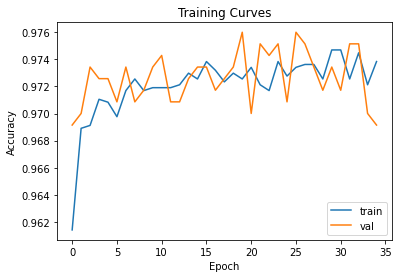

In [111]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = r"D:\saved_models\\ensemble_MLP-{epoch:02d}-{val_accuracy:.2f}.tf",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    mode = "max"
)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=15, verbose=1)
log_csv = tf.keras.callbacks.CSVLogger("my_logs.csv", separator=",", append=False)

history = my_ensemble_MLP.fit(
    ensemble_train,
    Y_train, 
    batch_size = 8,
    shuffle = True,
    epochs = 50, 
    validation_split = 0.2,
    callbacks = [early_stop, log_csv, checkpoint]
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

#_examples, img_height, img_width, img_channels): (5831, 200, 100, 1)
#_examples, #_classes): (5831, 2)

In [24]:
ensemble_model = tf.keras.models.load_model("D:\\brain_cancer_oct\saved_models\ensemble_MLP")
uncertainty = []

for i in range(1):
    metrics = ensemble_model.evaluate(ensemble_test, Y_test, batch_size=1)
    uncertainty.append(metrics[1])

uncertainty = np.asarray(uncertainty)
print("average accuracy: " + str(np.mean(uncertainty)))
print("std of accuracy: " + str(np.std(uncertainty)))

confusion_labels = Y_test[:,0]
confusion_pred = ensemble_model.predict(ensemble_test)
confusion_pred = confusion_pred[:,0] > 0.5
confusion_mtx = tf.math.confusion_matrix(confusion_labels, confusion_pred, num_classes=2)
print(confusion_mtx)

1610/1610 [==============================] - 2s 1ms/step - loss: 0.2872 - accuracy: 0.9503
average accuracy: 0.9503105878829956
std of accuracy: 0.0
tf.Tensor(
[[933  68]
 [ 16 593]], shape=(2, 2), dtype=int32)


In [117]:
# LOAD DATA FOR SEGMENTATION
# B-frames are processed in ascending order (e.g. frame 1 to frame 256) and sliced left to right
# for example, the first 20 elements of X_hist are from B-frame 1, the next 20 are from B-frame 2, etc.

hist_data_dir = r"D:\segmentation_test\4-12-2021-WM3-1\\"
hist_data = os.listdir(hist_data_dir)
X_hist = []
texture_domain = False

for file in hist_data:
    B_frame = process_bframe(hist_data_dir + file)
    slices = slice_bframe(B_frame, slice_width=100, step=1) # note the step size is 1
    num_slices = len(slices)

    for i in range(num_slices):
        B_frame_slice = slices[i]
        edge_depth = extract_edge(B_frame_slice)
        B_frame_slice = B_frame_slice[edge_depth:edge_depth+200]

        if(texture_domain):
            slice_texture = normalize(convert_to_texture(B_frame_slice, min_val, max_val))
            X_hist.append(slice_texture)
        else: 
            # B_frame_slice = 1 - ((B_frame_slice-min_val)/(max_val-min_val))
            X_hist.append(B_frame_slice)

X_hist = np.expand_dims(np.stack(X_hist, axis=0), axis=3)
print("Bframes: (#_examples, img_height, img_width, img_channels): " + str(X_hist.shape))

embedding_hist = load_embedding_data(X_hist)
print("Embedding: (#_examples, img_height, img_width, img_channels): " + str(embedding_hist.shape))


Bframes: (#_examples, img_height, img_width, img_channels): (5120, 200, 100, 1)
Embedding: (#_examples, img_height, img_width, img_channels): (5120, 128)


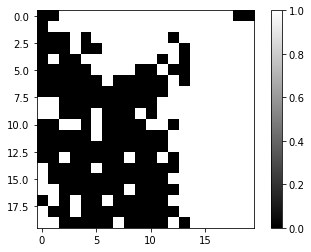

In [118]:
# PRODUCE SEGMENTATION MAP

# view predictions along a single B-frame
# frame_num = 100

# for i in range(20*frame_num, 20*(frame_num+1)):
#     slice = X_hist[i, :, :, :]
#     slice_input = np.expand_dims(X_hist[i, :, :, :], axis=0)
#     pred = loaded_model.predict(slice_input)

#     if (pred[:,0] > 0.5): 
#         title = "Cancer"
#     else:
#         title = "Non-cancer"

#     plt.imshow(slice, cmap="gray")
#     plt.title(title)
#     plt.colorbar()
#     plt.show()
#     time.sleep(1)
#     clear_output(wait=True)
    
ensemble_model = tf.keras.models.load_model("D:\saved_models\ensemble_MLP")
seg_map = ensemble_model.predict(embedding_hist, batch_size=1) > 0.5
seg_map = np.reshape(seg_map[:,0], (256,20))
plt.imshow(resize(seg_map, (20,20)), cmap='gray')
plt.colorbar()
plt.show()

Total B-frames: 19
[[0.26335198 0.736648  ]]


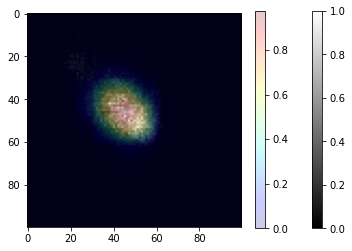

[[0.9701799  0.02982007]]


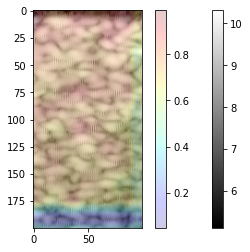

In [54]:
# PLOT GRAD-CAM MAP

model3 = B_frame_CNN(3, 'relu', 'same')
model3.load_weights("D:\saved_models\CNN_bframe").expect_partial()
model4 = texture_CNN(3, 'relu', 'same')
model4.load_weights("D:\saved_models\CNN_texture_suboptimal").expect_partial()
bframe_gradcam = model3.get_gradcam()
texture_gradcam = model4.get_gradcam()

# adapted from: https://keras.io/examples/vision/grad_cam/
def make_heatmap(input, model, is_texture=False):
    with tf.GradientTape() as tape:
        if(is_texture):
            last_conv_layer_output, preds = model(np.reshape(input, (1,100,100,1)))
        else: 
            last_conv_layer_output, preds = model(np.reshape(input, (1,200,100,1)))

        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

dir = r"D:\testing_data\cancer\6-08-2017-s2\\"
data = os.listdir(dir)
print("Total B-frames: " + str(len(data)))
B_frame = process_bframe(dir + data[6])
B_frame_slice = slice_bframe(B_frame, slice_width=100, step=3)[0]
edge_depth = extract_edge(B_frame_slice)
B_frame_slice = B_frame_slice[edge_depth:edge_depth+200]
slice_texture = normalize(convert_to_texture(B_frame_slice, min_val, max_val))

bframe_heat_map = make_heatmap(B_frame_slice, bframe_gradcam)
texture_heat_map = make_heatmap(slice_texture, texture_gradcam, True)

print(model4.predict(np.reshape(slice_texture, (1,100,100,1))))
plt.imshow(slice_texture, cmap="gray")
plt.colorbar()
plt.imshow(resize(texture_heat_map, (100,100)), cmap="jet", alpha=0.2)
plt.colorbar()
plt.show()

print(model3.predict(np.reshape(B_frame_slice, (1,200,100,1))))
plt.imshow(B_frame_slice, cmap="gray")
plt.colorbar()
plt.imshow(resize(bframe_heat_map, (200,100)), cmap="jet", alpha=0.2)
plt.colorbar()
plt.show()

In [ ]:
# UNUSED CODE ARCHIVE

# A generator object:
# - is used for oversized datasets that do not fit completely into RAM
# - loads training data in one batch at a time
# - heavily bottlenecks training speed

class Batch_Generator(tf.keras.utils.Sequence):
  def __init__(self, fnames, labels, batch_size):
    self.fnames = fnames
    self.labels = labels
    self.batch_size = batch_size

  # returns the number of B_frame batches in the training data
  # 1 B_frame batch = (20 // step) training examples
  def __len__(self):
    return np.floor(len(self.fnames) / self.batch_size).astype(int)
  
  # width, step, truncation depth, etc. are hyperparameters
  # hence, it is more convenient for only the B-frames to be permanently stored
  # returns arrays for the inputs and labels of the kth B-frame batch
  def __getitem__(self, k):
    start = k*self.batch_size
    stop = (k+1)*self.batch_size 
    batch_fnames = self.fnames[start:stop]
    batch_labels = self.labels[start:stop]
    batch_X = []
    batch_Y = []
    file_num = 0

    # all B-frame pre-processing
    for file in batch_fnames:
      B_frame = process_bframe(file)
      slices = slice_bframe(B_frame, slice_width=100, step=3)
      num_slices = len(slices)

      for i in range(num_slices):
          B_frame_slice = slices[i]
          edge_depth = extract_edge(B_frame_slice)
          B_frame_slice = normalize(B_frame_slice[edge_depth:edge_depth+1000, :])
          batch_X.append(B_frame_slice)

      frame_label = batch_labels[file_num]
      batch_Y += [frame_label] * num_slices # all slices from a given B-frame have the same label  
      file_num += 1

    batch_X, batch_Y = shuffle(batch_X, batch_Y)
    return np.expand_dims(np.stack(batch_X, axis=0), axis=3), np.stack(batch_Y, axis=0)
  
batch_generator = Batch_Generator(X_train_fnames, Y_train_bframe, batch_size=8) # a validation generator can be similarly defined
print("Total number of B-frame batches: " + str(batch_generator.__len__()))

x, y = batch_generator.__getitem__(1)
print("(#_examples, img_height, img_width, img_channels): " + str(x.shape))
print("(#_examples, #_classes): " + str(y.shape))

plt.tight_layout()
plt.subplots(4,4, figsize=(20,20))

for i in range(16):
  plt.subplot(4,4,i+1)
  input = x[i, :, :]
  label = y[i]

  if(label[0]==1):
    plt.title("cancer")
  else:
    plt.title("non-cancer")

  plt.axis("off")
  plt.imshow(input, cmap="gray")
  
plt.show()

# ----------------------------------------------------------------------------------------------------------------

# subclass definition of a keras model
class OCT_CNN(tf.keras.Model):

    # define the type of layers used in the model (order unimportant)
    def __init__(self, filter_size, activation, padding):
        super().__init__()
        # augmentation layers
        self.flip = tf.keras.layers.RandomFlip("horizontal_and_vertical")
        # self.zoom = tf.keras.layers.RandomZoom((-0.2, 0.2))
        # self.rotation = tf.keras.layers.RandomRotation(0.5)
        # self.contrast = tf.keras.layers.RandomContrast(0.2)

        # convolutional layers
        self.c1 = tf.keras.layers.Conv2D(96, 8, strides=(2,1), activation=activation, padding=padding)
        self.p1 = tf.keras.layers.MaxPooling2D(filter_size, strides=(2,1))
        self.c2 = tf.keras.layers.Conv2D(256, filter_size, strides=2, activation=activation, padding=padding)
        self.p2 = tf.keras.layers.MaxPooling2D(filter_size, strides=2)
        self.c3 = tf.keras.layers.Conv2D(256, filter_size, strides=2, activation=activation, padding=padding)

        self.c4 = tf.keras.layers.Conv2D(384, filter_size, strides=1, activation=activation, padding=padding)
        self.c5 = tf.keras.layers.Conv2D(384, filter_size, strides=2, activation=activation, padding=padding)
        self.c6 = tf.keras.layers.Conv2D(256, filter_size, strides=2, activation=activation, padding=padding)
        # self.p3 = tf.keras.layers.MaxPooling2D(filter_size, strides=2)
        
        # dense layers
        self.f1 = tf.keras.layers.Flatten()
        self.dropout1 = tf.keras.layers.Dropout(0.5)
        self.d1 = tf.keras.layers.Dense(1024, activation=activation)
        self.dropout2 = tf.keras.layers.Dropout(0.5)
        self.d2 = tf.keras.layers.Dense(2, activation='softmax')

    # define order of forward propagation
    def call(self, inputs):
        x = self.flip(inputs)
        # x = self.zoom(x)
        # x = self.rotation(x)
        # x = self.contrast(x)

        x = self.c1(x)
        x = self.p1(x)
        x = self.c2(x)
        x = self.p2(x)
        x = self.c3(x)

        x = self.c4(x)
        x = self.c5(x)
        x = self.c6(x)
        # x = self.p3(x)
        
        x = self.f1(x)
        x = self.dropout1(x)        
        x = self.d1(x)
        x = self.dropout2(x)
        return self.d2(x)
        
    def model(self):
        inputs = tf.keras.Input(shape=(400,100,1))
        return tf.keras.Model(inputs=[inputs], outputs=self.call(inputs))

brain_CNN_rect = OCT_CNN(3, 'relu', 'same')
brain_CNN_rect.model().summary()
smoothed_BCE = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1) # softens penalty for wrong predictions
brain_CNN_rect.compile(
    optimizer="sgd", 
    loss=smoothed_BCE, 
    metrics=["accuracy"])
